In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U nltk
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.1 MB/s 
     |████████████████████████████████| 182 kB 63.4 MB/s 
     |████████████████████████████████| 7.6 MB 27.8 MB/s 


In [ ]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import nn
from torch.optim import Adam
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import random
import re
import nltk
import string
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import confusion_matrix 

In [ ]:
sample_submission = pd.read_csv("sample_submission.csv")
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [ ]:
X_train, y_train = train_test_split(df_train, test_size = 0.25, random_state = 42)

In [ ]:
print('Train Data')
df_train.head()

Train Data


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
print('\n Test Data')
df_test.head()


 Test Data


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
def glove_loaded():
    embedded= {}
    path = '/content/drive/MyDrive/GLOVE and FastText/glove.twitter.27B.100d.txt'
    with open(path, 'r') as txt:
        for line in txt:
            sequences = line.split()
            word = sequences[0]
            vectors = np.asarray(sequences[1:], 'float32')
            embedded[word] = vectors
    return embedded

glove_dict = glove_loaded()

In [ ]:
max_number_tokens = 30
length_word_vectors = 100

In [ ]:
class LstmTweetDataset(Dataset):
    def __init__(self, df, dict_embedded):
        self.embeddings_dict = dict_embedded
        sentences = df.text.values.tolist()
        sentences = [self._preprocess(line) for line in sentences]
        self.sentences_word_vector = self._sentences2vectors(sentences)  
        self.sentences = sentences
        if 'target' in df:
            classes = df.target.values.tolist()
            self.labels = classes

    def _preprocess(self, sentence):
        sentence = self._remove_amp(sentence)
        sentence = self._remove_links(sentence)
        sentence = self._remove_hashes(sentence)
        sentence = self._remove_retweets(sentence)
        sentence = self._remove_mentions(sentence)
        sentence = self._remove_multiple_spaces(sentence)
        sentence = self._lowercase(sentence)
        sentence = self._remove_punctuation(sentence)
        tokens = self._tokenize(sentence)
        sentence = self._stitch_text_tokens_together(tokens)
        return sentence.strip()

    def _remove_amp(self, sentence):
        return sentence.replace("&amp;", " ")
    
    def _remove_links(self, sentence):
        return re.sub(r'https?:\/\/[^\s\n\r]+', ' ', sentence)
    
    def _remove_hashes(self, sentence):
        return re.sub(r'#', ' ', sentence)
    
    def _remove_retweets(self, sentence):
        return re.sub(r'^RT[\s]+', ' ', sentence)

    def _remove_mentions(self, sentence):
        return re.sub(r'(@.*?)[\s]', ' ', sentence)
    
    def _remove_multiple_spaces(self, sentence):
        return re.sub(r'\s+', ' ', sentence)
    
    def _lowercase(self, sentence):
        return sentence.lower()
    
    def _remove_punctuation(self, sentence):
        return ''.join(character for character in sentence if character not in string.punctuation)
    
    def _tokenize(self, sentence):
        return nltk.word_tokenize(sentence, language="english")
    
    def _stopword_filtering(self, tokens):
        stop_words = nltk.corpus.stopwords.words('english')
        return [token for token in tokens if token not in stop_words]
    
    def _lemmatization(self, tokens):
        wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
        return [wordnet_lemmatizer.lemmatize(token, pos='v') for token in tokens]

    def _stemming(self, tokens):
        porter = nltk.stem.porter.PorterStemmer()
        return [porter.stem(token) for token in tokens]

    def _stitch_text_tokens_together(self, text_tokens):
        return " ".join(text_tokens)
    
    def _sentences2vectors(self, sentences):
        regularized_tokens = np.array([self._sentence2tokens(sentence) for sentence in sentences])
        final_training_data = np.zeros((regularized_tokens.shape[0], regularized_tokens.shape[1], length_word_vectors), dtype='float32')
        for data_index in range(regularized_tokens.shape[0]):
            for text_index in range(regularized_tokens.shape[1]):
                text = regularized_tokens[data_index][text_index]
                final_training_data[data_index][text_index] = self.embeddings_dict[text] if text in self.embeddings_dict else np.zeros(100,)
        return final_training_data
    
    def _sentence2tokens(self, sentence):
        tokens = self._tokenize(sentence)
        if len(tokens) < max_number_tokens:
            final_tokens = ['' for i in range(max_number_tokens)]
            final_tokens[:len(tokens)] = tokens
            return final_tokens
        else:
            return tokens[:max_number_tokens]

    def __len__(self):
        return len(self.sentences_word_vector)

    def __getitem__(self, index):
        sentence = self.sentences_word_vector[index]
        label = -1
        if hasattr(self, 'labels'):
            label = self.labels[index]
        return sentence, label

In [ ]:
class LstmTweetClassifier(nn.Module):
    def __init__(self):
        super(LstmTweetClassifier, self).__init__()
        self.rnn = nn.LSTM(input_size = length_word_vectors, hidden_size = 64,  num_layers = 1, batch_first = True)

        self.linear1 = nn.Linear(64, 32)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)
        out = self.linear1(r_out[:, -1, :])
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

In [ ]:
def train_with_lstm(model, train_dataloader, val_dataloader, learning_rate, epochs, saved_model_name = "best_lstm_model.pt"):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    loss_func = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    model = model.to(device)
    loss_func = loss_func.to(device)
    training_loss_record = []
    val_loss_record = []
    best_val_loss = sys.float_info.max
    no_promotion_count = 0
    for epoch in range(epochs):
        count_for_successfully_pred_in_training_set = 0
        total_train_loss = 0
        model.train()
        for train_input, train_label in tqdm(train_dataloader):
            optimizer.zero_grad()
            train_input = train_input.to(device)
            train_label = train_label.to(device)
            output = model(train_input)
            loss = loss_func(output, train_label.float().unsqueeze(1))
            total_train_loss += loss.item()
            acc = ((output >= 0.5).int() == train_label.unsqueeze(1)).sum().item()
            count_for_successfully_pred_in_training_set += acc
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            count_for_successfully_pred_in_val_set = 0
            total_val_loss = 0
            model.eval()
            for val_input, val_label in tqdm(val_dataloader):
                val_input = val_input.to(device)
                val_label = val_label.to(device)
                output = model(val_input)
                loss = loss_func(output, val_label.float().unsqueeze(1))
                total_val_loss += loss.item()
                acc = ((output >= 0.5).int() == val_label.unsqueeze(1)).sum().item()
                count_for_successfully_pred_in_val_set += acc
            
            avg_train_loss = total_train_loss / len(train_dataloader)
            avg_val_loss = total_val_loss / len(val_dataloader)
            avg_train_acc = count_for_successfully_pred_in_training_set / len(train_dataloader.dataset)
            avg_val_acc = count_for_successfully_pred_in_val_set / len(val_dataloader.dataset)
            print(f'Epochs: {epoch + 1} '
                  f'| Train Loss: {avg_train_loss: .4f} '
                  f'| Train Accuracy: {avg_train_acc: .4f} '
                  f'| Val Loss: {avg_val_loss: .4f} '
                  f'| Val Accuracy: {avg_val_acc: .4f}')
            training_loss_record.append(avg_train_loss)
            val_loss_record.append(avg_val_loss)
            
            if best_val_loss > avg_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model, saved_model_name)
                print("Saved model")
                no_promotion_count = 0
            else:
                no_promotion_count += 1
                
            if no_promotion_count >= 3:
                print("Early stopping")
                break
    plt.ioff()
    # plot testing loss
    plt.figure(1)
    plt.plot(training_loss_record, lw=1)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Training Loss')
    plt.title('Train Data')
    # plot training loss
    plt.figure(2)
    plt.plot(val_loss_record, lw=1)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Validation Loss')
    plt.title('Validation Data')
    plt.show()

In [ ]:
train_dataloader = DataLoader(LstmTweetDataset(X_train, glove_dict), batch_size=32, shuffle=True)
val_dataloader = DataLoader(LstmTweetDataset(y_train, glove_dict), batch_size=32)
test_dataloader = DataLoader(LstmTweetDataset(df_test, glove_dict), batch_size=32)

In [ ]:
count = 0
for sentence in (train_dataloader.dataset).sentences:
    tokens = nltk.word_tokenize(sentence, language="english")
    count += len(tokens)
print(f'The average length of preprocessed sentences = {count / len((train_dataloader.dataset).sentences)}')

The average length of preprocessed sentences = 13.700472937467158


100%|██████████| 60/60 [00:00<00:00, 223.90it/s]


Epochs: 1 | Train Loss:  0.6919 | Train Accuracy:  0.5693 | Val Loss:  0.6914 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 217.33it/s]


Epochs: 2 | Train Loss:  0.6911 | Train Accuracy:  0.5695 | Val Loss:  0.6905 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 203.93it/s]


Epochs: 3 | Train Loss:  0.6903 | Train Accuracy:  0.5695 | Val Loss:  0.6897 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 186.44it/s]


Epochs: 4 | Train Loss:  0.6896 | Train Accuracy:  0.5695 | Val Loss:  0.6890 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 190.39it/s]


Epochs: 5 | Train Loss:  0.6888 | Train Accuracy:  0.5695 | Val Loss:  0.6882 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 213.07it/s]


Epochs: 6 | Train Loss:  0.6880 | Train Accuracy:  0.5695 | Val Loss:  0.6873 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 225.66it/s]


Epochs: 7 | Train Loss:  0.6871 | Train Accuracy:  0.5695 | Val Loss:  0.6863 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 218.25it/s]


Epochs: 8 | Train Loss:  0.6860 | Train Accuracy:  0.5695 | Val Loss:  0.6853 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 206.90it/s]


Epochs: 9 | Train Loss:  0.6851 | Train Accuracy:  0.5695 | Val Loss:  0.6841 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 203.24it/s]


Epochs: 10 | Train Loss:  0.6840 | Train Accuracy:  0.5695 | Val Loss:  0.6830 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 227.98it/s]


Epochs: 11 | Train Loss:  0.6828 | Train Accuracy:  0.5695 | Val Loss:  0.6815 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 195.77it/s]


Epochs: 12 | Train Loss:  0.6813 | Train Accuracy:  0.5695 | Val Loss:  0.6796 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 220.86it/s]


Epochs: 13 | Train Loss:  0.6796 | Train Accuracy:  0.5695 | Val Loss:  0.6771 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 206.95it/s]


Epochs: 14 | Train Loss:  0.6762 | Train Accuracy:  0.5695 | Val Loss:  0.6730 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 229.02it/s]


Epochs: 15 | Train Loss:  0.6715 | Train Accuracy:  0.5695 | Val Loss:  0.6655 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 224.46it/s]


Epochs: 16 | Train Loss:  0.6621 | Train Accuracy:  0.5695 | Val Loss:  0.6525 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 210.44it/s]


Epochs: 17 | Train Loss:  0.6499 | Train Accuracy:  0.5695 | Val Loss:  0.6389 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 212.91it/s]


Epochs: 18 | Train Loss:  0.6384 | Train Accuracy:  0.5695 | Val Loss:  0.6282 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 228.71it/s]


Epochs: 19 | Train Loss:  0.6295 | Train Accuracy:  0.5695 | Val Loss:  0.6199 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 217.37it/s]


Epochs: 20 | Train Loss:  0.6222 | Train Accuracy:  0.5695 | Val Loss:  0.6114 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 219.69it/s]


Epochs: 21 | Train Loss:  0.6152 | Train Accuracy:  0.5695 | Val Loss:  0.6056 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 210.75it/s]


Epochs: 22 | Train Loss:  0.6090 | Train Accuracy:  0.5695 | Val Loss:  0.5998 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 226.08it/s]


Epochs: 23 | Train Loss:  0.6038 | Train Accuracy:  0.5695 | Val Loss:  0.5953 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 219.58it/s]


Epochs: 24 | Train Loss:  0.5991 | Train Accuracy:  0.5695 | Val Loss:  0.5901 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 223.09it/s]


Epochs: 25 | Train Loss:  0.5946 | Train Accuracy:  0.5698 | Val Loss:  0.5859 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 130.29it/s]


Epochs: 26 | Train Loss:  0.5911 | Train Accuracy:  0.5698 | Val Loss:  0.5834 | Val Accuracy:  0.5741
Saved model


100%|██████████| 60/60 [00:00<00:00, 97.74it/s]


Epochs: 27 | Train Loss:  0.5873 | Train Accuracy:  0.5700 | Val Loss:  0.5793 | Val Accuracy:  0.5735
Saved model


100%|██████████| 60/60 [00:00<00:00, 220.20it/s]


Epochs: 28 | Train Loss:  0.5847 | Train Accuracy:  0.5705 | Val Loss:  0.5759 | Val Accuracy:  0.5746
Saved model


100%|██████████| 60/60 [00:00<00:00, 214.29it/s]


Epochs: 29 | Train Loss:  0.5809 | Train Accuracy:  0.5721 | Val Loss:  0.5731 | Val Accuracy:  0.5767
Saved model


100%|██████████| 60/60 [00:00<00:00, 223.43it/s]


Epochs: 30 | Train Loss:  0.5785 | Train Accuracy:  0.5737 | Val Loss:  0.5694 | Val Accuracy:  0.5798
Saved model


100%|██████████| 60/60 [00:00<00:00, 229.43it/s]


Epochs: 31 | Train Loss:  0.5744 | Train Accuracy:  0.5845 | Val Loss:  0.5661 | Val Accuracy:  0.5903
Saved model


100%|██████████| 60/60 [00:00<00:00, 208.66it/s]


Epochs: 32 | Train Loss:  0.5703 | Train Accuracy:  0.5959 | Val Loss:  0.5637 | Val Accuracy:  0.6087
Saved model


100%|██████████| 60/60 [00:00<00:00, 191.52it/s]


Epochs: 33 | Train Loss:  0.5670 | Train Accuracy:  0.6146 | Val Loss:  0.5620 | Val Accuracy:  0.6339
Saved model


100%|██████████| 60/60 [00:00<00:00, 184.87it/s]


Epochs: 34 | Train Loss:  0.5645 | Train Accuracy:  0.6371 | Val Loss:  0.5590 | Val Accuracy:  0.6560
Saved model


100%|██████████| 60/60 [00:00<00:00, 229.95it/s]


Epochs: 35 | Train Loss:  0.5617 | Train Accuracy:  0.6534 | Val Loss:  0.5565 | Val Accuracy:  0.6696
Saved model


100%|██████████| 60/60 [00:00<00:00, 204.07it/s]


Epochs: 36 | Train Loss:  0.5594 | Train Accuracy:  0.6716 | Val Loss:  0.5570 | Val Accuracy:  0.7027


100%|██████████| 60/60 [00:00<00:00, 228.63it/s]


Epochs: 37 | Train Loss:  0.5568 | Train Accuracy:  0.7028 | Val Loss:  0.5539 | Val Accuracy:  0.7206
Saved model


100%|██████████| 60/60 [00:00<00:00, 218.05it/s]


Epochs: 38 | Train Loss:  0.5546 | Train Accuracy:  0.7215 | Val Loss:  0.5516 | Val Accuracy:  0.7342
Saved model


100%|██████████| 60/60 [00:00<00:00, 202.40it/s]


Epochs: 39 | Train Loss:  0.5534 | Train Accuracy:  0.7367 | Val Loss:  0.5517 | Val Accuracy:  0.7511


100%|██████████| 60/60 [00:00<00:00, 229.44it/s]


Epochs: 40 | Train Loss:  0.5513 | Train Accuracy:  0.7513 | Val Loss:  0.5505 | Val Accuracy:  0.7631
Saved model


100%|██████████| 60/60 [00:00<00:00, 226.77it/s]


Epochs: 41 | Train Loss:  0.5497 | Train Accuracy:  0.7628 | Val Loss:  0.5471 | Val Accuracy:  0.7647
Saved model


100%|██████████| 60/60 [00:00<00:00, 222.80it/s]


Epochs: 42 | Train Loss:  0.5479 | Train Accuracy:  0.7649 | Val Loss:  0.5482 | Val Accuracy:  0.7805


100%|██████████| 60/60 [00:00<00:00, 220.72it/s]


Epochs: 43 | Train Loss:  0.5459 | Train Accuracy:  0.7714 | Val Loss:  0.5477 | Val Accuracy:  0.7815


100%|██████████| 60/60 [00:00<00:00, 223.21it/s]


Epochs: 44 | Train Loss:  0.5447 | Train Accuracy:  0.7772 | Val Loss:  0.5453 | Val Accuracy:  0.7831
Saved model


100%|██████████| 60/60 [00:00<00:00, 213.56it/s]


Epochs: 45 | Train Loss:  0.5433 | Train Accuracy:  0.7784 | Val Loss:  0.5440 | Val Accuracy:  0.7836
Saved model


100%|██████████| 60/60 [00:00<00:00, 231.62it/s]


Epochs: 46 | Train Loss:  0.5425 | Train Accuracy:  0.7816 | Val Loss:  0.5436 | Val Accuracy:  0.7841
Saved model


100%|██████████| 60/60 [00:00<00:00, 193.95it/s]


Epochs: 47 | Train Loss:  0.5401 | Train Accuracy:  0.7828 | Val Loss:  0.5421 | Val Accuracy:  0.7847
Saved model


100%|██████████| 60/60 [00:00<00:00, 217.92it/s]


Epochs: 48 | Train Loss:  0.5393 | Train Accuracy:  0.7826 | Val Loss:  0.5405 | Val Accuracy:  0.7857
Saved model


100%|██████████| 60/60 [00:00<00:00, 222.48it/s]


Epochs: 49 | Train Loss:  0.5369 | Train Accuracy:  0.7847 | Val Loss:  0.5391 | Val Accuracy:  0.7868
Saved model


100%|██████████| 60/60 [00:00<00:00, 217.45it/s]


Epochs: 50 | Train Loss:  0.5362 | Train Accuracy:  0.7858 | Val Loss:  0.5394 | Val Accuracy:  0.7873


100%|██████████| 60/60 [00:00<00:00, 220.76it/s]


Epochs: 51 | Train Loss:  0.5340 | Train Accuracy:  0.7881 | Val Loss:  0.5381 | Val Accuracy:  0.7852
Saved model


100%|██████████| 60/60 [00:00<00:00, 227.57it/s]


Epochs: 52 | Train Loss:  0.5328 | Train Accuracy:  0.7884 | Val Loss:  0.5360 | Val Accuracy:  0.7873
Saved model


100%|██████████| 60/60 [00:00<00:00, 224.97it/s]


Epochs: 53 | Train Loss:  0.5312 | Train Accuracy:  0.7891 | Val Loss:  0.5352 | Val Accuracy:  0.7868
Saved model


100%|██████████| 60/60 [00:00<00:00, 210.99it/s]


Epochs: 54 | Train Loss:  0.5305 | Train Accuracy:  0.7893 | Val Loss:  0.5338 | Val Accuracy:  0.7878
Saved model


100%|██████████| 60/60 [00:00<00:00, 223.83it/s]


Epochs: 55 | Train Loss:  0.5282 | Train Accuracy:  0.7896 | Val Loss:  0.5333 | Val Accuracy:  0.7868
Saved model


100%|██████████| 60/60 [00:00<00:00, 210.42it/s]


Epochs: 56 | Train Loss:  0.5284 | Train Accuracy:  0.7888 | Val Loss:  0.5327 | Val Accuracy:  0.7847
Saved model


100%|██████████| 60/60 [00:00<00:00, 222.56it/s]


Epochs: 57 | Train Loss:  0.5268 | Train Accuracy:  0.7902 | Val Loss:  0.5317 | Val Accuracy:  0.7852
Saved model


100%|██████████| 60/60 [00:00<00:00, 217.26it/s]


Epochs: 58 | Train Loss:  0.5261 | Train Accuracy:  0.7884 | Val Loss:  0.5319 | Val Accuracy:  0.7826


100%|██████████| 60/60 [00:00<00:00, 203.84it/s]


Epochs: 59 | Train Loss:  0.5242 | Train Accuracy:  0.7910 | Val Loss:  0.5310 | Val Accuracy:  0.7826
Saved model


100%|██████████| 60/60 [00:00<00:00, 208.86it/s]


Epochs: 60 | Train Loss:  0.5237 | Train Accuracy:  0.7912 | Val Loss:  0.5295 | Val Accuracy:  0.7868
Saved model


100%|██████████| 60/60 [00:00<00:00, 206.24it/s]


Epochs: 61 | Train Loss:  0.5217 | Train Accuracy:  0.7905 | Val Loss:  0.5283 | Val Accuracy:  0.7873
Saved model


100%|██████████| 60/60 [00:00<00:00, 209.16it/s]


Epochs: 62 | Train Loss:  0.5205 | Train Accuracy:  0.7902 | Val Loss:  0.5272 | Val Accuracy:  0.7878
Saved model


100%|██████████| 60/60 [00:00<00:00, 209.47it/s]


Epochs: 63 | Train Loss:  0.5204 | Train Accuracy:  0.7917 | Val Loss:  0.5282 | Val Accuracy:  0.7857


100%|██████████| 60/60 [00:00<00:00, 209.35it/s]


Epochs: 64 | Train Loss:  0.5186 | Train Accuracy:  0.7905 | Val Loss:  0.5275 | Val Accuracy:  0.7836


100%|██████████| 60/60 [00:00<00:00, 202.23it/s]


Epochs: 65 | Train Loss:  0.5176 | Train Accuracy:  0.7905 | Val Loss:  0.5240 | Val Accuracy:  0.7878
Saved model


100%|██████████| 60/60 [00:00<00:00, 190.61it/s]


Epochs: 66 | Train Loss:  0.5157 | Train Accuracy:  0.7896 | Val Loss:  0.5240 | Val Accuracy:  0.7889


100%|██████████| 60/60 [00:00<00:00, 207.55it/s]


Epochs: 67 | Train Loss:  0.5155 | Train Accuracy:  0.7921 | Val Loss:  0.5219 | Val Accuracy:  0.7889
Saved model


100%|██████████| 60/60 [00:00<00:00, 203.45it/s]


Epochs: 68 | Train Loss:  0.5142 | Train Accuracy:  0.7923 | Val Loss:  0.5231 | Val Accuracy:  0.7868


100%|██████████| 60/60 [00:00<00:00, 219.80it/s]


Epochs: 69 | Train Loss:  0.5133 | Train Accuracy:  0.7909 | Val Loss:  0.5217 | Val Accuracy:  0.7873
Saved model


100%|██████████| 60/60 [00:00<00:00, 224.81it/s]


Epochs: 70 | Train Loss:  0.5115 | Train Accuracy:  0.7919 | Val Loss:  0.5220 | Val Accuracy:  0.7841


100%|██████████| 60/60 [00:00<00:00, 215.44it/s]


Epochs: 71 | Train Loss:  0.5115 | Train Accuracy:  0.7926 | Val Loss:  0.5203 | Val Accuracy:  0.7852
Saved model


100%|██████████| 60/60 [00:00<00:00, 201.13it/s]


Epochs: 72 | Train Loss:  0.5093 | Train Accuracy:  0.7921 | Val Loss:  0.5198 | Val Accuracy:  0.7841
Saved model


100%|██████████| 60/60 [00:00<00:00, 186.67it/s]


Epochs: 73 | Train Loss:  0.5085 | Train Accuracy:  0.7930 | Val Loss:  0.5182 | Val Accuracy:  0.7852
Saved model


100%|██████████| 60/60 [00:00<00:00, 204.01it/s]


Epochs: 74 | Train Loss:  0.5071 | Train Accuracy:  0.7928 | Val Loss:  0.5163 | Val Accuracy:  0.7878
Saved model


100%|██████████| 60/60 [00:00<00:00, 183.83it/s]


Epochs: 75 | Train Loss:  0.5060 | Train Accuracy:  0.7928 | Val Loss:  0.5156 | Val Accuracy:  0.7862
Saved model


100%|██████████| 60/60 [00:00<00:00, 218.47it/s]


Epochs: 76 | Train Loss:  0.5049 | Train Accuracy:  0.7942 | Val Loss:  0.5160 | Val Accuracy:  0.7847


100%|██████████| 60/60 [00:00<00:00, 219.40it/s]


Epochs: 77 | Train Loss:  0.5036 | Train Accuracy:  0.7951 | Val Loss:  0.5138 | Val Accuracy:  0.7883
Saved model


100%|██████████| 60/60 [00:00<00:00, 209.73it/s]


Epochs: 78 | Train Loss:  0.5032 | Train Accuracy:  0.7938 | Val Loss:  0.5151 | Val Accuracy:  0.7852


100%|██████████| 60/60 [00:00<00:00, 217.16it/s]


Epochs: 79 | Train Loss:  0.5021 | Train Accuracy:  0.7940 | Val Loss:  0.5138 | Val Accuracy:  0.7862
Saved model


100%|██████████| 60/60 [00:00<00:00, 200.39it/s]


Epochs: 80 | Train Loss:  0.5014 | Train Accuracy:  0.7966 | Val Loss:  0.5131 | Val Accuracy:  0.7862
Saved model


100%|██████████| 60/60 [00:00<00:00, 202.84it/s]


Epochs: 81 | Train Loss:  0.5002 | Train Accuracy:  0.7958 | Val Loss:  0.5128 | Val Accuracy:  0.7857
Saved model


100%|██████████| 60/60 [00:00<00:00, 221.15it/s]


Epochs: 82 | Train Loss:  0.4999 | Train Accuracy:  0.7968 | Val Loss:  0.5109 | Val Accuracy:  0.7862
Saved model


100%|██████████| 60/60 [00:00<00:00, 205.10it/s]


Epochs: 83 | Train Loss:  0.4981 | Train Accuracy:  0.7968 | Val Loss:  0.5107 | Val Accuracy:  0.7862
Saved model


100%|██████████| 60/60 [00:00<00:00, 208.01it/s]


Epochs: 84 | Train Loss:  0.4971 | Train Accuracy:  0.7963 | Val Loss:  0.5114 | Val Accuracy:  0.7836


100%|██████████| 60/60 [00:00<00:00, 207.72it/s]


Epochs: 85 | Train Loss:  0.4964 | Train Accuracy:  0.7972 | Val Loss:  0.5085 | Val Accuracy:  0.7889
Saved model


100%|██████████| 60/60 [00:00<00:00, 207.95it/s]


Epochs: 86 | Train Loss:  0.4955 | Train Accuracy:  0.7973 | Val Loss:  0.5086 | Val Accuracy:  0.7857


100%|██████████| 60/60 [00:00<00:00, 212.65it/s]


Epochs: 87 | Train Loss:  0.4935 | Train Accuracy:  0.7977 | Val Loss:  0.5084 | Val Accuracy:  0.7857
Saved model


100%|██████████| 60/60 [00:00<00:00, 202.39it/s]


Epochs: 88 | Train Loss:  0.4929 | Train Accuracy:  0.7972 | Val Loss:  0.5076 | Val Accuracy:  0.7857
Saved model


100%|██████████| 60/60 [00:00<00:00, 213.12it/s]


Epochs: 89 | Train Loss:  0.4925 | Train Accuracy:  0.7994 | Val Loss:  0.5084 | Val Accuracy:  0.7847


100%|██████████| 60/60 [00:00<00:00, 207.85it/s]


Epochs: 90 | Train Loss:  0.4911 | Train Accuracy:  0.7989 | Val Loss:  0.5064 | Val Accuracy:  0.7862
Saved model


100%|██████████| 60/60 [00:00<00:00, 208.34it/s]


Epochs: 91 | Train Loss:  0.4897 | Train Accuracy:  0.7980 | Val Loss:  0.5055 | Val Accuracy:  0.7868
Saved model


100%|██████████| 60/60 [00:00<00:00, 212.93it/s]


Epochs: 92 | Train Loss:  0.4887 | Train Accuracy:  0.7984 | Val Loss:  0.5031 | Val Accuracy:  0.7889
Saved model


100%|██████████| 60/60 [00:00<00:00, 209.24it/s]


Epochs: 93 | Train Loss:  0.4878 | Train Accuracy:  0.7984 | Val Loss:  0.5024 | Val Accuracy:  0.7894
Saved model


100%|██████████| 60/60 [00:00<00:00, 202.10it/s]


Epochs: 94 | Train Loss:  0.4866 | Train Accuracy:  0.7994 | Val Loss:  0.5027 | Val Accuracy:  0.7873


100%|██████████| 60/60 [00:00<00:00, 215.76it/s]


Epochs: 95 | Train Loss:  0.4857 | Train Accuracy:  0.7986 | Val Loss:  0.5012 | Val Accuracy:  0.7878
Saved model


100%|██████████| 60/60 [00:00<00:00, 202.51it/s]


Epochs: 96 | Train Loss:  0.4851 | Train Accuracy:  0.8001 | Val Loss:  0.5028 | Val Accuracy:  0.7831


100%|██████████| 60/60 [00:00<00:00, 214.00it/s]


Epochs: 97 | Train Loss:  0.4839 | Train Accuracy:  0.8028 | Val Loss:  0.5007 | Val Accuracy:  0.7873
Saved model


100%|██████████| 60/60 [00:00<00:00, 227.71it/s]


Epochs: 98 | Train Loss:  0.4825 | Train Accuracy:  0.8014 | Val Loss:  0.4996 | Val Accuracy:  0.7868
Saved model


100%|██████████| 60/60 [00:00<00:00, 202.37it/s]


Epochs: 99 | Train Loss:  0.4809 | Train Accuracy:  0.8007 | Val Loss:  0.5002 | Val Accuracy:  0.7868


100%|██████████| 60/60 [00:00<00:00, 206.75it/s]


Epochs: 100 | Train Loss:  0.4809 | Train Accuracy:  0.8028 | Val Loss:  0.4996 | Val Accuracy:  0.7868


100%|██████████| 60/60 [00:00<00:00, 209.27it/s]


Epochs: 101 | Train Loss:  0.4797 | Train Accuracy:  0.8035 | Val Loss:  0.4990 | Val Accuracy:  0.7873
Saved model


100%|██████████| 60/60 [00:00<00:00, 215.37it/s]


Epochs: 102 | Train Loss:  0.4789 | Train Accuracy:  0.8028 | Val Loss:  0.4968 | Val Accuracy:  0.7894
Saved model


100%|██████████| 60/60 [00:00<00:00, 221.52it/s]


Epochs: 103 | Train Loss:  0.4782 | Train Accuracy:  0.8022 | Val Loss:  0.4964 | Val Accuracy:  0.7889
Saved model


100%|██████████| 60/60 [00:00<00:00, 187.19it/s]


Epochs: 104 | Train Loss:  0.4770 | Train Accuracy:  0.8031 | Val Loss:  0.4977 | Val Accuracy:  0.7862


100%|██████████| 60/60 [00:00<00:00, 211.95it/s]


Epochs: 105 | Train Loss:  0.4761 | Train Accuracy:  0.8043 | Val Loss:  0.4963 | Val Accuracy:  0.7868
Saved model


100%|██████████| 60/60 [00:00<00:00, 221.91it/s]


Epochs: 106 | Train Loss:  0.4751 | Train Accuracy:  0.8045 | Val Loss:  0.4986 | Val Accuracy:  0.7836


100%|██████████| 60/60 [00:00<00:00, 216.54it/s]


Epochs: 107 | Train Loss:  0.4742 | Train Accuracy:  0.8038 | Val Loss:  0.4949 | Val Accuracy:  0.7889
Saved model


100%|██████████| 60/60 [00:00<00:00, 218.34it/s]


Epochs: 108 | Train Loss:  0.4733 | Train Accuracy:  0.8057 | Val Loss:  0.4934 | Val Accuracy:  0.7920
Saved model


100%|██████████| 60/60 [00:00<00:00, 205.24it/s]


Epochs: 109 | Train Loss:  0.4727 | Train Accuracy:  0.8031 | Val Loss:  0.4949 | Val Accuracy:  0.7873


100%|██████████| 60/60 [00:00<00:00, 219.78it/s]


Epochs: 110 | Train Loss:  0.4717 | Train Accuracy:  0.8040 | Val Loss:  0.4952 | Val Accuracy:  0.7878


100%|██████████| 60/60 [00:00<00:00, 207.01it/s]


Epochs: 111 | Train Loss:  0.4712 | Train Accuracy:  0.8057 | Val Loss:  0.4936 | Val Accuracy:  0.7899
Early stopping


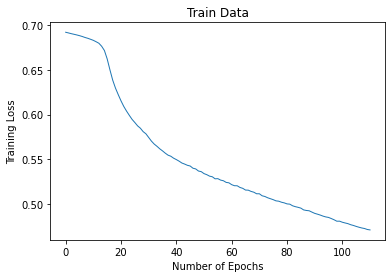

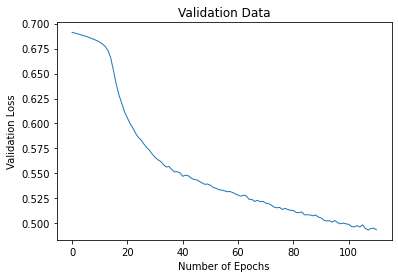

In [ ]:
lstm_tweet_classifier = LstmTweetClassifier()
learning_rate = 1e-5
epochs = 400
train_with_lstm(lstm_tweet_classifier, train_dataloader, val_dataloader, learning_rate, epochs, "best_lstm_model.pt")
#best testing score with LSTM= 0.78976

In [ ]:
def disaster_predictions_for_lstm(model, loader):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model = model.to(device)
    results_predictions = []
    with torch.no_grad():
        model.eval()
        for data_input, _ in tqdm(loader):
            data_input = data_input.to(device)
            output = model(data_input)
            output = (output > 0.5).int()
            results_predictions.append(output)
    return torch.cat(results_predictions, 0).cpu().numpy()

In [ ]:
predict_model = torch.load("best_lstm_model.pt")
test_data_prediction = disaster_predictions_for_lstm(predict_model, test_dataloader)
test_data_prediction = test_data_prediction.reshape(-1,)

sample_submission["target"] = test_data_prediction
display(sample_submission.head(10))

100%|██████████| 102/102 [00:01<00:00, 99.15it/s]

[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [ ]:
sample_submission.to_csv("lstm_submission.csv", index=False)

# Bidirectional LSTM

In [ ]:
class BidirectionalLstmTweetClassifier(nn.Module):
    def __init__(self):
        super(BidirectionalLstmTweetClassifier, self).__init__()

        self.hidden_size = 64
        self.rnn = nn.LSTM(
            input_size = length_word_vectors,
            hidden_size = self.hidden_size,
            num_layers = 1,
            bidirectional = True,
            batch_first = True,
        )

        self.linear1 = nn.Linear(self.hidden_size * 2, 32)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)

        out = self.linear1(r_out[:, -1, :])
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

100%|██████████| 60/60 [00:00<00:00, 106.88it/s]


Epochs: 1 | Train Loss:  0.7026 | Train Accuracy:  0.4305 | Val Loss:  0.7022 | Val Accuracy:  0.4270
Saved model


100%|██████████| 60/60 [00:00<00:00, 62.56it/s]


Epochs: 2 | Train Loss:  0.7009 | Train Accuracy:  0.4305 | Val Loss:  0.7005 | Val Accuracy:  0.4270
Saved model


100%|██████████| 60/60 [00:00<00:00, 120.77it/s]


Epochs: 3 | Train Loss:  0.6994 | Train Accuracy:  0.4305 | Val Loss:  0.6990 | Val Accuracy:  0.4270
Saved model


100%|██████████| 60/60 [00:00<00:00, 110.46it/s]


Epochs: 4 | Train Loss:  0.6980 | Train Accuracy:  0.4305 | Val Loss:  0.6975 | Val Accuracy:  0.4270
Saved model


100%|██████████| 60/60 [00:00<00:00, 111.11it/s]


Epochs: 5 | Train Loss:  0.6965 | Train Accuracy:  0.4305 | Val Loss:  0.6959 | Val Accuracy:  0.4270
Saved model


100%|██████████| 60/60 [00:00<00:00, 113.44it/s]


Epochs: 6 | Train Loss:  0.6951 | Train Accuracy:  0.4323 | Val Loss:  0.6944 | Val Accuracy:  0.4296
Saved model


100%|██████████| 60/60 [00:00<00:00, 105.17it/s]


Epochs: 7 | Train Loss:  0.6936 | Train Accuracy:  0.4495 | Val Loss:  0.6929 | Val Accuracy:  0.5720
Saved model


100%|██████████| 60/60 [00:00<00:00, 101.85it/s]


Epochs: 8 | Train Loss:  0.6921 | Train Accuracy:  0.5693 | Val Loss:  0.6913 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 117.27it/s]


Epochs: 9 | Train Loss:  0.6906 | Train Accuracy:  0.5695 | Val Loss:  0.6897 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 113.90it/s]


Epochs: 10 | Train Loss:  0.6889 | Train Accuracy:  0.5695 | Val Loss:  0.6875 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 115.48it/s]


Epochs: 11 | Train Loss:  0.6863 | Train Accuracy:  0.5695 | Val Loss:  0.6839 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 111.15it/s]


Epochs: 12 | Train Loss:  0.6814 | Train Accuracy:  0.5695 | Val Loss:  0.6756 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 114.71it/s]


Epochs: 13 | Train Loss:  0.6715 | Train Accuracy:  0.5695 | Val Loss:  0.6632 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 118.18it/s]


Epochs: 14 | Train Loss:  0.6598 | Train Accuracy:  0.5695 | Val Loss:  0.6499 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 107.49it/s]


Epochs: 15 | Train Loss:  0.6480 | Train Accuracy:  0.5695 | Val Loss:  0.6384 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 115.75it/s]


Epochs: 16 | Train Loss:  0.6381 | Train Accuracy:  0.5695 | Val Loss:  0.6277 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 117.40it/s]


Epochs: 17 | Train Loss:  0.6292 | Train Accuracy:  0.5695 | Val Loss:  0.6188 | Val Accuracy:  0.5730
Saved model


100%|██████████| 60/60 [00:00<00:00, 113.31it/s]


Epochs: 18 | Train Loss:  0.6216 | Train Accuracy:  0.5695 | Val Loss:  0.6120 | Val Accuracy:  0.5735
Saved model


100%|██████████| 60/60 [00:00<00:00, 106.83it/s]


Epochs: 19 | Train Loss:  0.6151 | Train Accuracy:  0.5696 | Val Loss:  0.6047 | Val Accuracy:  0.5741
Saved model


100%|██████████| 60/60 [00:00<00:00, 115.24it/s]


Epochs: 20 | Train Loss:  0.6091 | Train Accuracy:  0.5702 | Val Loss:  0.5983 | Val Accuracy:  0.5746
Saved model


100%|██████████| 60/60 [00:00<00:00, 111.61it/s]


Epochs: 21 | Train Loss:  0.6024 | Train Accuracy:  0.5709 | Val Loss:  0.5918 | Val Accuracy:  0.5751
Saved model


100%|██████████| 60/60 [00:00<00:00, 113.97it/s]


Epochs: 22 | Train Loss:  0.5980 | Train Accuracy:  0.5742 | Val Loss:  0.5868 | Val Accuracy:  0.5788
Saved model


100%|██████████| 60/60 [00:00<00:00, 112.49it/s]


Epochs: 23 | Train Loss:  0.5927 | Train Accuracy:  0.5842 | Val Loss:  0.5811 | Val Accuracy:  0.5898
Saved model


100%|██████████| 60/60 [00:00<00:00, 108.89it/s]


Epochs: 24 | Train Loss:  0.5878 | Train Accuracy:  0.5941 | Val Loss:  0.5760 | Val Accuracy:  0.6098
Saved model


100%|██████████| 60/60 [00:00<00:00, 116.21it/s]


Epochs: 25 | Train Loss:  0.5832 | Train Accuracy:  0.6213 | Val Loss:  0.5707 | Val Accuracy:  0.6324
Saved model


100%|██████████| 60/60 [00:00<00:00, 115.34it/s]


Epochs: 26 | Train Loss:  0.5786 | Train Accuracy:  0.6372 | Val Loss:  0.5663 | Val Accuracy:  0.6591
Saved model


100%|██████████| 60/60 [00:00<00:00, 114.96it/s]


Epochs: 27 | Train Loss:  0.5750 | Train Accuracy:  0.6574 | Val Loss:  0.5621 | Val Accuracy:  0.6838
Saved model


100%|██████████| 60/60 [00:00<00:00, 116.90it/s]


Epochs: 28 | Train Loss:  0.5711 | Train Accuracy:  0.6805 | Val Loss:  0.5581 | Val Accuracy:  0.7033
Saved model


100%|██████████| 60/60 [00:00<00:00, 115.10it/s]


Epochs: 29 | Train Loss:  0.5670 | Train Accuracy:  0.7066 | Val Loss:  0.5544 | Val Accuracy:  0.7264
Saved model


100%|██████████| 60/60 [00:00<00:00, 113.42it/s]


Epochs: 30 | Train Loss:  0.5640 | Train Accuracy:  0.7288 | Val Loss:  0.5511 | Val Accuracy:  0.7458
Saved model


100%|██████████| 60/60 [00:00<00:00, 115.07it/s]


Epochs: 31 | Train Loss:  0.5602 | Train Accuracy:  0.7492 | Val Loss:  0.5480 | Val Accuracy:  0.7595
Saved model


100%|██████████| 60/60 [00:00<00:00, 111.57it/s]


Epochs: 32 | Train Loss:  0.5575 | Train Accuracy:  0.7620 | Val Loss:  0.5452 | Val Accuracy:  0.7726
Saved model


100%|██████████| 60/60 [00:00<00:00, 115.33it/s]


Epochs: 33 | Train Loss:  0.5533 | Train Accuracy:  0.7707 | Val Loss:  0.5424 | Val Accuracy:  0.7757
Saved model


100%|██████████| 60/60 [00:00<00:00, 118.08it/s]


Epochs: 34 | Train Loss:  0.5509 | Train Accuracy:  0.7772 | Val Loss:  0.5399 | Val Accuracy:  0.7768
Saved model


100%|██████████| 60/60 [00:00<00:00, 119.34it/s]


Epochs: 35 | Train Loss:  0.5478 | Train Accuracy:  0.7791 | Val Loss:  0.5379 | Val Accuracy:  0.7852
Saved model


100%|██████████| 60/60 [00:00<00:00, 115.66it/s]


Epochs: 36 | Train Loss:  0.5445 | Train Accuracy:  0.7816 | Val Loss:  0.5357 | Val Accuracy:  0.7873
Saved model


100%|██████████| 60/60 [00:00<00:00, 112.01it/s]


Epochs: 37 | Train Loss:  0.5424 | Train Accuracy:  0.7803 | Val Loss:  0.5334 | Val Accuracy:  0.7868
Saved model


100%|██████████| 60/60 [00:00<00:00, 114.52it/s]


Epochs: 38 | Train Loss:  0.5392 | Train Accuracy:  0.7788 | Val Loss:  0.5323 | Val Accuracy:  0.7868
Saved model


100%|██████████| 60/60 [00:00<00:00, 114.70it/s]


Epochs: 39 | Train Loss:  0.5374 | Train Accuracy:  0.7803 | Val Loss:  0.5294 | Val Accuracy:  0.7878
Saved model


100%|██████████| 60/60 [00:00<00:00, 109.77it/s]


Epochs: 40 | Train Loss:  0.5346 | Train Accuracy:  0.7817 | Val Loss:  0.5276 | Val Accuracy:  0.7868
Saved model


100%|██████████| 60/60 [00:00<00:00, 110.67it/s]


Epochs: 41 | Train Loss:  0.5319 | Train Accuracy:  0.7831 | Val Loss:  0.5252 | Val Accuracy:  0.7894
Saved model


100%|██████████| 60/60 [00:00<00:00, 112.09it/s]


Epochs: 42 | Train Loss:  0.5307 | Train Accuracy:  0.7817 | Val Loss:  0.5242 | Val Accuracy:  0.7868
Saved model


100%|██████████| 60/60 [00:00<00:00, 119.09it/s]


Epochs: 43 | Train Loss:  0.5276 | Train Accuracy:  0.7842 | Val Loss:  0.5224 | Val Accuracy:  0.7873
Saved model


100%|██████████| 60/60 [00:00<00:00, 116.07it/s]


Epochs: 44 | Train Loss:  0.5254 | Train Accuracy:  0.7830 | Val Loss:  0.5207 | Val Accuracy:  0.7868
Saved model


100%|██████████| 60/60 [00:00<00:00, 112.62it/s]


Epochs: 45 | Train Loss:  0.5228 | Train Accuracy:  0.7856 | Val Loss:  0.5193 | Val Accuracy:  0.7868
Saved model


100%|██████████| 60/60 [00:00<00:00, 116.04it/s]


Epochs: 46 | Train Loss:  0.5205 | Train Accuracy:  0.7851 | Val Loss:  0.5181 | Val Accuracy:  0.7836
Saved model


100%|██████████| 60/60 [00:00<00:00, 71.06it/s]


Epochs: 47 | Train Loss:  0.5184 | Train Accuracy:  0.7872 | Val Loss:  0.5172 | Val Accuracy:  0.7820
Saved model


100%|██████████| 60/60 [00:00<00:00, 67.92it/s]


Epochs: 48 | Train Loss:  0.5164 | Train Accuracy:  0.7882 | Val Loss:  0.5155 | Val Accuracy:  0.7815
Saved model


100%|██████████| 60/60 [00:00<00:00, 117.78it/s]


Epochs: 49 | Train Loss:  0.5142 | Train Accuracy:  0.7868 | Val Loss:  0.5144 | Val Accuracy:  0.7820
Saved model


100%|██████████| 60/60 [00:00<00:00, 113.48it/s]


Epochs: 50 | Train Loss:  0.5117 | Train Accuracy:  0.7896 | Val Loss:  0.5132 | Val Accuracy:  0.7847
Saved model


100%|██████████| 60/60 [00:00<00:00, 111.34it/s]


Epochs: 51 | Train Loss:  0.5101 | Train Accuracy:  0.7896 | Val Loss:  0.5121 | Val Accuracy:  0.7836
Saved model


100%|██████████| 60/60 [00:00<00:00, 115.87it/s]


Epochs: 52 | Train Loss:  0.5085 | Train Accuracy:  0.7902 | Val Loss:  0.5112 | Val Accuracy:  0.7836
Saved model


100%|██████████| 60/60 [00:00<00:00, 118.67it/s]


Epochs: 53 | Train Loss:  0.5066 | Train Accuracy:  0.7893 | Val Loss:  0.5099 | Val Accuracy:  0.7862
Saved model


100%|██████████| 60/60 [00:00<00:00, 114.07it/s]


Epochs: 54 | Train Loss:  0.5061 | Train Accuracy:  0.7912 | Val Loss:  0.5093 | Val Accuracy:  0.7847
Saved model


100%|██████████| 60/60 [00:00<00:00, 114.66it/s]


Epochs: 55 | Train Loss:  0.5041 | Train Accuracy:  0.7905 | Val Loss:  0.5083 | Val Accuracy:  0.7847
Saved model


100%|██████████| 60/60 [00:00<00:00, 115.53it/s]


Epochs: 56 | Train Loss:  0.5020 | Train Accuracy:  0.7935 | Val Loss:  0.5066 | Val Accuracy:  0.7873
Saved model


100%|██████████| 60/60 [00:00<00:00, 116.84it/s]


Epochs: 57 | Train Loss:  0.5012 | Train Accuracy:  0.7930 | Val Loss:  0.5064 | Val Accuracy:  0.7847
Saved model


100%|██████████| 60/60 [00:00<00:00, 118.68it/s]


Epochs: 58 | Train Loss:  0.4994 | Train Accuracy:  0.7921 | Val Loss:  0.5055 | Val Accuracy:  0.7831
Saved model


100%|██████████| 60/60 [00:00<00:00, 110.96it/s]


Epochs: 59 | Train Loss:  0.4986 | Train Accuracy:  0.7930 | Val Loss:  0.5046 | Val Accuracy:  0.7836
Saved model


100%|██████████| 60/60 [00:00<00:00, 110.16it/s]


Epochs: 60 | Train Loss:  0.4976 | Train Accuracy:  0.7909 | Val Loss:  0.5031 | Val Accuracy:  0.7878
Saved model


100%|██████████| 60/60 [00:00<00:00, 109.77it/s]


Epochs: 61 | Train Loss:  0.4957 | Train Accuracy:  0.7924 | Val Loss:  0.5038 | Val Accuracy:  0.7805


100%|██████████| 60/60 [00:00<00:00, 111.05it/s]


Epochs: 62 | Train Loss:  0.4938 | Train Accuracy:  0.7938 | Val Loss:  0.5030 | Val Accuracy:  0.7805
Saved model


100%|██████████| 60/60 [00:00<00:00, 114.07it/s]


Epochs: 63 | Train Loss:  0.4923 | Train Accuracy:  0.7945 | Val Loss:  0.5007 | Val Accuracy:  0.7862
Saved model


100%|██████████| 60/60 [00:00<00:00, 118.91it/s]


Epochs: 64 | Train Loss:  0.4916 | Train Accuracy:  0.7926 | Val Loss:  0.4982 | Val Accuracy:  0.7915
Saved model


100%|██████████| 60/60 [00:00<00:00, 114.08it/s]


Epochs: 65 | Train Loss:  0.4902 | Train Accuracy:  0.7933 | Val Loss:  0.4995 | Val Accuracy:  0.7852


100%|██████████| 60/60 [00:00<00:00, 118.28it/s]


Epochs: 66 | Train Loss:  0.4893 | Train Accuracy:  0.7942 | Val Loss:  0.4968 | Val Accuracy:  0.7894
Saved model


100%|██████████| 60/60 [00:00<00:00, 114.76it/s]


Epochs: 67 | Train Loss:  0.4887 | Train Accuracy:  0.7951 | Val Loss:  0.4965 | Val Accuracy:  0.7889
Saved model


100%|██████████| 60/60 [00:00<00:00, 118.55it/s]


Epochs: 68 | Train Loss:  0.4871 | Train Accuracy:  0.7956 | Val Loss:  0.4957 | Val Accuracy:  0.7889
Saved model


100%|██████████| 60/60 [00:00<00:00, 117.81it/s]


Epochs: 69 | Train Loss:  0.4855 | Train Accuracy:  0.7956 | Val Loss:  0.4936 | Val Accuracy:  0.7883
Saved model


100%|██████████| 60/60 [00:00<00:00, 113.84it/s]


Epochs: 70 | Train Loss:  0.4836 | Train Accuracy:  0.7959 | Val Loss:  0.4919 | Val Accuracy:  0.7899
Saved model


100%|██████████| 60/60 [00:00<00:00, 110.11it/s]


Epochs: 71 | Train Loss:  0.4837 | Train Accuracy:  0.7970 | Val Loss:  0.4935 | Val Accuracy:  0.7878


100%|██████████| 60/60 [00:00<00:00, 107.84it/s]


Epochs: 72 | Train Loss:  0.4822 | Train Accuracy:  0.7951 | Val Loss:  0.4923 | Val Accuracy:  0.7883


100%|██████████| 60/60 [00:00<00:00, 114.52it/s]


Epochs: 73 | Train Loss:  0.4813 | Train Accuracy:  0.7977 | Val Loss:  0.4924 | Val Accuracy:  0.7899
Early stopping


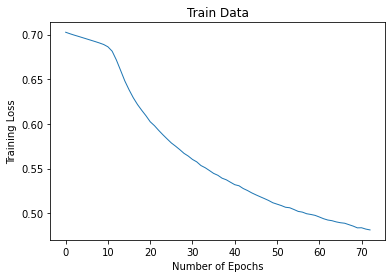

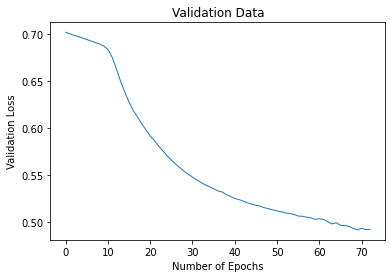

In [ ]:
bidirectional_lstm_tweet_classifier = BidirectionalLstmTweetClassifier()
learning_rate = 1e-5
epochs = 400
train_with_lstm(bidirectional_lstm_tweet_classifier, train_dataloader, val_dataloader, learning_rate, epochs, "best_bidirectional_lstm_model.pt")

In [ ]:
predict_model = torch.load("best_bidirectional_lstm_model.pt")
test_data_prediction = disaster_predictions_for_lstm(predict_model, test_dataloader)
test_data_prediction = test_data_prediction.reshape(-1,)
sample_submission["target"] = test_data_prediction
display(sample_submission.head(10))

100%|██████████| 102/102 [00:00<00:00, 114.15it/s]


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [ ]:
sample_submission.to_csv("bi_lstm_submission.csv", index=False)

In [ ]:
df_scraped = pd.read_csv("scrape_test_edited_highlighted_final.csv", encoding = "ISO-8859-1")
df_scraped.head()

for col in df_scraped.columns:
    print(col)
df_scraped.drop(["target","RoBERTa", "Accuracy", "Unnamed: 5"], axis=1)

keyword
text
target
RoBERTa
Accuracy
Unnamed: 5


,keyword,text
0,ablaze,"Yesterday, at Igando, two men allegedly robbed..."
1,ablaze,- NDLEA sets ablaze the N194 Billion worth of ...
2,ablaze,Putin's cancelled speech appears to have set M...
3,ablaze,"Seeing all over the country, people wearing ma..."
4,ablaze,Death of a girl set ablaze in Dumka | Jharkhan...
...,...,...
2014,wrecked,This the second time I wrecked my car this yea...
2015,wrecked,@MikeBaggz Biden wrecked tens of thousands of ...
2016,wrecked,I do not like driving! My nerves be wrecked dr...
2017,wrecked,"im so sick and tired of work, this week reall..."


In [ ]:
scraped_dataloader = DataLoader(LstmTweetDataset(df_scraped, glove_dict), batch_size=32)

In [ ]:
predict_model_scraped_lstm = torch.load("best_lstm_model.pt")

In [ ]:
test_data_prediction_scraped_lstm = disaster_predictions_for_lstm(predict_model_scraped_lstm, scraped_dataloader)

100%|██████████| 64/64 [00:00<00:00, 119.88it/s]


In [ ]:
confusion_matrix(test_data_prediction_scraped_lstm,df_scraped["target"])

array([[834,  69],
       [500, 616]])

In [ ]:
predict_model_scraped_bilstm = torch.load("best_bidirectional_lstm_model.pt")

In [ ]:
test_data_prediction_scraped_bilstm= disaster_predictions_for_lstm(predict_model_scraped_bilstm, scraped_dataloader)

100%|██████████| 64/64 [00:00<00:00, 66.77it/s]


In [ ]:
confusion_matrix(test_data_prediction_scraped_bilstm,df_scraped["target"])

array([[898,  74],
       [436, 611]])